## dependencies

In [ ]:
!pip install fbprophet
!pip install holidays
!pip install pmdarima
!pip install neuralprophet

## Imports

In [3]:
# Modular Imports
# import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from userInputs import importFile,getInfo
from engineerings import getDateColumns,time_engineering,train_test_split,interpolateTarget
from plots import basicPlot,decompositionPlot,fbprophet_plots,neural_prophet_plots
from init import INIT
import joblib
from pmdarima import auto_arima
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from fbprophet import Prophet
from neuralprophet import NeuralProphet
import holidays

## Main Function

This is Time Series Folder and All functions and files will be contained here
#### For now use only CSV files ####
Enter filename for TimeSeries : stock.csv
#### RUNNING WAIT ####
extension is csv
We have a csv file
This file has 8 columns and 100 rows
The columns found are :
Index(['Unnamed:_0', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')
Enter the target column : Close

The date columns found are :
['Date']
Enter the primary date column : Date
Enter the forecast period in the format years,months,days : 0,0,1
The forecast period is : 1 days
INFO SAVED!

INIT STARTED!
IMPORTING NECESSARY FILES
#### RUNNING WAIT ####
extension is csv
We have a csv file
This file has 8 columns and 251 rows
(251, 8)

#### Preparing Data For Univariate Analysis! ####

(251, 2)
		 stripping spaces, symbols, and lower casing all entries
done ...
		 Replacing empty and invalid strings
done ...
		 Replacing commas if present in Currencies
done ...
		 Finding Numeric Columns
done 

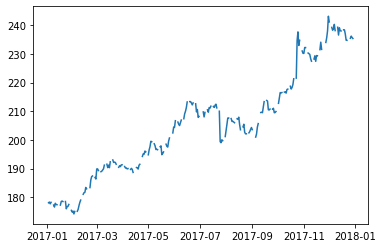

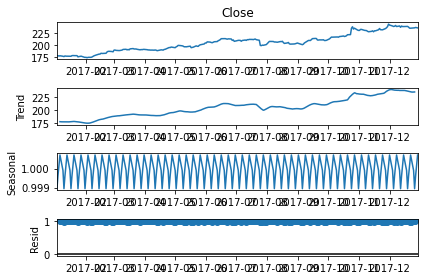


40.0% done on frontEndProgessBar

Train_Test_Split (FIT SAMPLE / HOLD_OUT SAMPLE SPLIT DONE!)

Preparing Holiday list and DataFrame with -5 and 5 window

#### FITTING AUTO-ARIMA MODEL #### RUNNING WAIT ####

The mean squared error for Auto Arima is
69.4392675978842


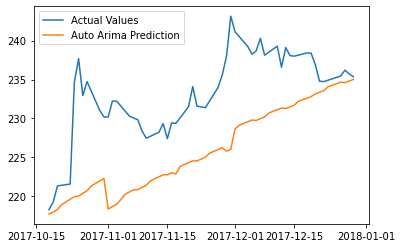

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



#### FBPROPHET MODEL #### RUNNING WAIT ####

The mean squared error for FBProphet is
47.91872943377335


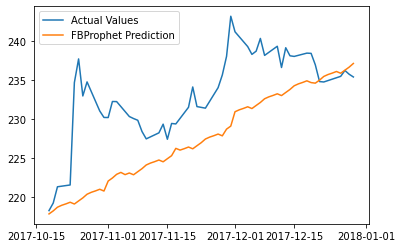

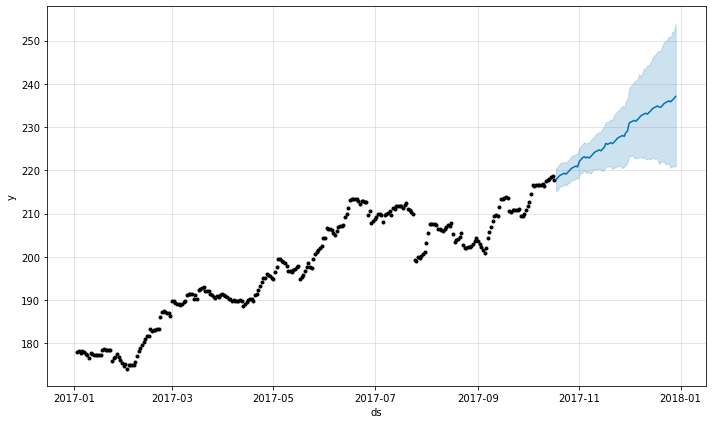

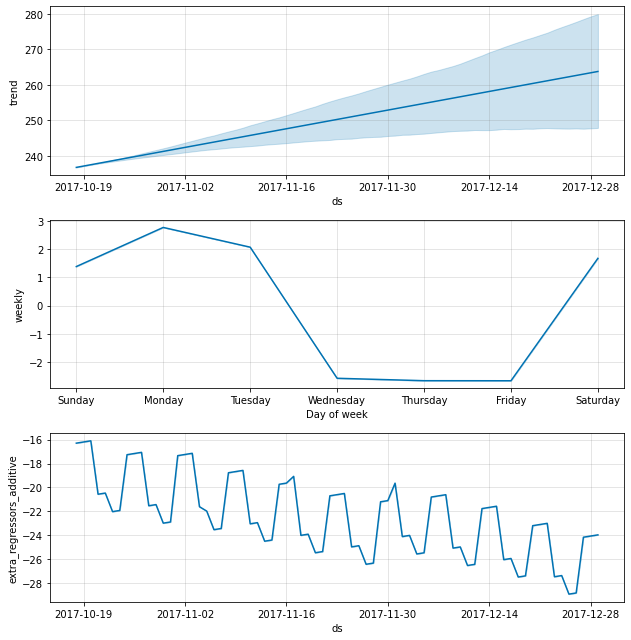

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:nprophet.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[4/500]:   1%|▎                                | 4/500 [00:00<00:13, 36.29it/s, MSELoss=2.74, MAE=63.9, RegLoss=0]


#### NEURAL PROPHET MODEL #### RUNNING WAIT ####


Epoch[500/500]: 100%|██████████████████████████| 500/500 [00:12<00:00, 39.84it/s, MSELoss=0.00834, MAE=3.66, RegLoss=0]



The mean squared error for Neural Prophet is
361.71584870320686


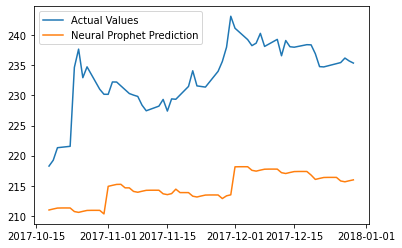

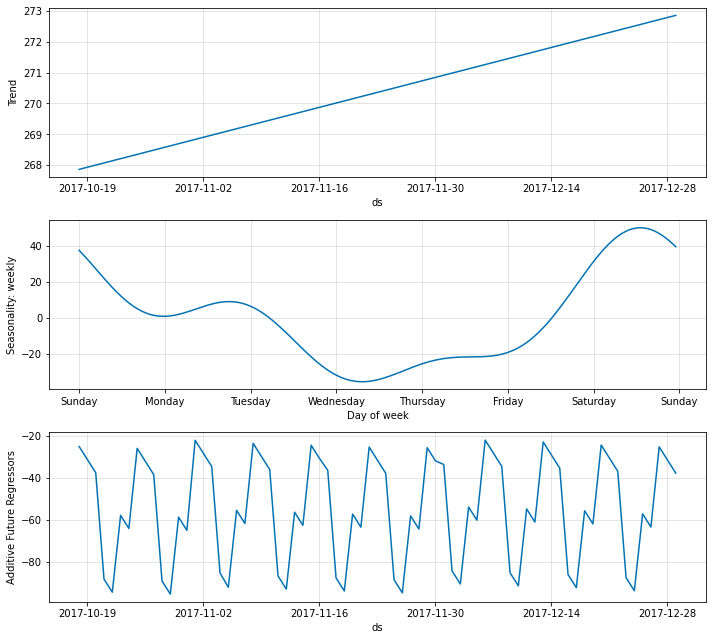

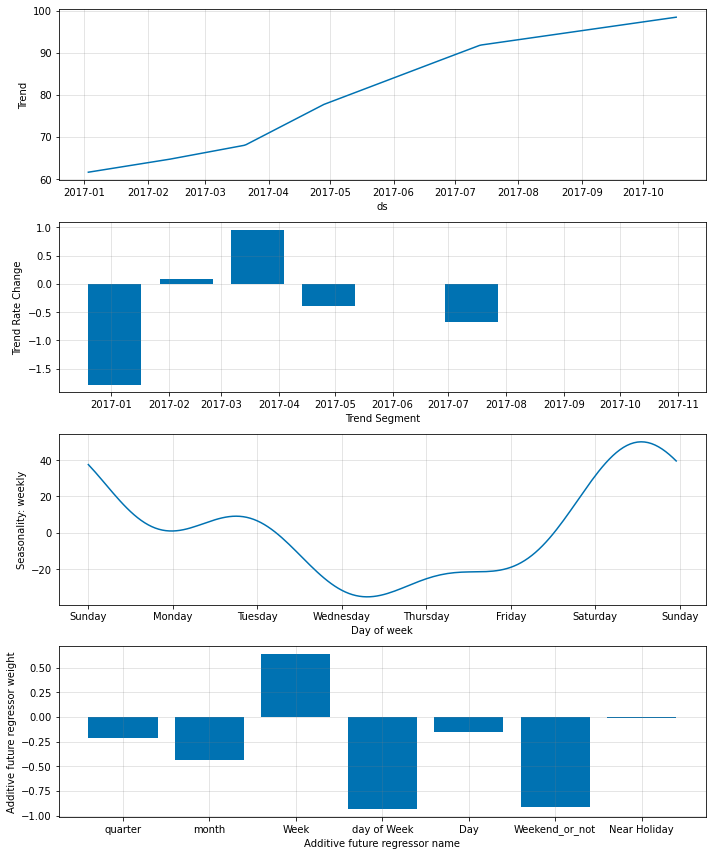


#### Code run successfully ####



In [4]:
def main(test=False,props=None):
    print('This is Time Series Folder and All functions and files will be contained here')
    print('#### For now use only CSV files ####')
    ## Importing File ## We need to store CSV files in test folder in TimeSeries ##
    if not test:
        # For single file manual testing
        path = input('Enter filename for TimeSeries : ').strip()
        if path == '':
            print('\nNo File Selected, QUITTING!')
            return 1,0
        df,_ = importFile(path,nrows=100)
    else:
        # For Automated Testing
        df,_ = importFile(props[path],nrows=100)
    # Stripping trailing and leading spaces and replacing spaces in between with _
    df.columns = [x.strip().replace(' ','_') for x in df.columns]
    datecols,_ = getDateColumns(df.select_dtypes('object'))
    if len(datecols) == 0:
        print('No datecolumns found, QUITTING!')
        return None,None

    info = getInfo(df.columns,datecols) # Get Target and Primary Date Column

    if not info:
        print('QUITTING!')
        return None,None

    info['DateColumns'] = datecols
    joblib.dump(info,'info');print('INFO SAVED!')

    # Reimporting complete data, slicing date and target columns,
    props = INIT(path,info)
    frontEndProgressBar = 0.05
    print('\n{}% done on frontEndProgessBar\n'.format(frontEndProgressBar*100))

    props = time_engineering(props)
    if props == dict():
        print('QUITTING!');return None,None
    frontEndProgressBar = 0.10
    print('\n{}% done on frontEndProgessBar'.format(frontEndProgressBar*100))

    basicPlot(props)
    frontEndProgressBar = 0.20
    print('\n{}% done on frontEndProgessBar'.format(frontEndProgressBar*100))
    
    print('\nApplying Linear Interpolation to the Training Target Column')    
    props = interpolateTarget(props)
    frontEndProgressBar = 0.30
    print('\n{}% done on frontEndProgessBar'.format(frontEndProgressBar*100))
    
    decompositionPlot(props)
    frontEndProgressBar = 0.40
    print('\n{}% done on frontEndProgessBar'.format(frontEndProgressBar*100))

    props['Margin'] = int(len(props['df'])*0.8)
    X_train,y_train,X_test,y_test = train_test_split(props)
    print('\nTrain_Test_Split (FIT SAMPLE / HOLD_OUT SAMPLE SPLIT DONE!)')
    
# =============================================================================
#     print('\nPower Transforming Exogenous Features!')
#     PT = PowerTransformer()
#     col_names = X_train.columns
#     X_train = pd.DataFrame(PT.fit_transform(X_train),columns=col_names)
#     X_test = pd.DataFrame(PT.fit_transform(X_test),columns=col_names)
# =============================================================================
    
    print('\nPreparing Holiday list and DataFrame with -5 and 5 window')
    us_hols = holidays.UnitedStates(years=props['df'].index.year.to_list())
    us_hols_df = pd.DataFrame(us_hols.items(),columns=['ds','holiday'])
    us_hols_df['lower_window'] = -5
    us_hols_df['upper_window'] = 5
    
    MODEL_COMPARISON = pd.DataFrame()
    mc_cols_index = 0
    
# =============================================================================
#     AUTO ARIMA
# =============================================================================

    print('\n#### FITTING AUTO-ARIMA MODEL #### RUNNING WAIT ####')
    AutoArimaModel = auto_arima(y_train,exogenous=X_train,seasonal=True,suppress_warnings=True)
    AutoArimaForecasts = pd.Series(AutoArimaModel.predict(len(X_test),exogenous=X_test),index=y_test.index)
    
    print('\nThe mean squared error for Auto Arima is')
    print(mean_squared_error(y_test,AutoArimaForecasts))
    props['AutoArima'] = AutoArimaModel
    MODEL_COMPARISON.loc[mc_cols_index,'Model'] = AutoArimaModel
    MODEL_COMPARISON.loc[mc_cols_index,'Model Name'] = 'Auto Regressive Integrated Moving Average'
    MODEL_COMPARISON.loc[mc_cols_index,'Mean Absolute Percentage Error'] = smape(y_test, AutoArimaForecasts)
    MODEL_COMPARISON.loc[mc_cols_index,'Mean Squared Error'] = mean_squared_error(y_test,AutoArimaForecasts)
    MODEL_COMPARISON.loc[mc_cols_index,'Mean Absolute Error'] = mean_absolute_error(y_test,AutoArimaForecasts)
    plt.plot(y_test,label='Actual Values')
    plt.plot(AutoArimaForecasts,label='Auto Arima Prediction')
    plt.legend(loc=2)
    plt.show()
    mc_cols_index += 1
    
# =============================================================================
#     AUTO ARIMA
# =============================================================================

# =============================================================================
# FBPROPHET
# =============================================================================

    print('\n#### FBPROPHET MODEL #### RUNNING WAIT ####')
    fbprophetModel = Prophet()
    dsy = pd.concat([X_train,y_train.rename('y')],axis=1)
    dsy['ds'] = dsy.index
    for col in X_train.columns:
        fbprophetModel.add_regressor(col)    
    future = X_test
    future['ds'] = X_test.index
    fbProphetForecasts = fbprophetModel.fit(dsy).predict(future)
    fbProphetForecasts.index = y_test.index
    print('\nThe mean squared error for FBProphet is') 
    print(mean_squared_error(y_test,fbProphetForecasts['yhat']))
    props['FBProphet'] = fbprophetModel
    MODEL_COMPARISON.loc[mc_cols_index,'Model'] = fbprophetModel
    MODEL_COMPARISON.loc[mc_cols_index,'Model Name'] = 'Facebook Prophet'
    MODEL_COMPARISON.loc[mc_cols_index,'Mean Absolute Percentage Error'] = smape(y_test, fbProphetForecasts['yhat'])
    MODEL_COMPARISON.loc[mc_cols_index,'Mean Squared Error'] = mean_squared_error(y_test,fbProphetForecasts['yhat'])
    MODEL_COMPARISON.loc[mc_cols_index,'Mean Absolute Error'] = mean_absolute_error(y_test,fbProphetForecasts['yhat'])
    plt.plot(y_test,label='Actual Values')
    plt.plot(fbProphetForecasts['yhat'],label='FBProphet Prediction')
    plt.legend(loc=2)
    plt.show()
    fbprophet_plots(fbprophetModel,fbProphetForecasts)
    mc_cols_index += 1

# =============================================================================
# FBPROPHET
# =============================================================================

# =============================================================================
# NEURALPROPHET
# =============================================================================

    print('\n#### NEURAL PROPHET MODEL #### RUNNING WAIT ####')
    neuralProphetModel = NeuralProphet(learning_rate=0.01,epochs=500,n_forecasts=10,loss_func='mse')
    for col in X_train.columns:
        neuralProphetModel.add_future_regressor(col)  
    epoch_df_info = neuralProphetModel.fit(dsy,freq='D')
    future = neuralProphetModel.make_future_dataframe(dsy,periods=len(y_test),regressors_df=X_test)
    future.index = X_test.index
    neuralProphetForecasts = neuralProphetModel.predict(future)
    neuralProphetForecasts.index = y_test.index
    print('\nThe mean squared error for Neural Prophet is') 
    print(mean_squared_error(y_test,neuralProphetForecasts['yhat1']))
    props['NeuralProphet'] = neuralProphetModel
    MODEL_COMPARISON.loc[mc_cols_index,'Model'] = neuralProphetModel
    MODEL_COMPARISON.loc[mc_cols_index,'Model Name'] = 'Neural Prophet'
    MODEL_COMPARISON.loc[mc_cols_index,'Mean Absolute Percentage Error'] = smape(y_test, neuralProphetForecasts['yhat1'])
    MODEL_COMPARISON.loc[mc_cols_index,'Mean Squared Error'] = mean_squared_error(y_test,neuralProphetForecasts['yhat1'])
    MODEL_COMPARISON.loc[mc_cols_index,'Mean Absolute Error'] = mean_absolute_error(y_test,neuralProphetForecasts['yhat1'])
    plt.plot(y_test,label='Actual Values')
    plt.plot(neuralProphetForecasts['yhat1'],label='Neural Prophet Prediction')
    plt.legend(loc=2)
    plt.show()
    neural_prophet_plots(neuralProphetModel,neuralProphetForecasts)
    mc_cols_index += 1
    
# =============================================================================
# NEURALPROPHET
# =============================================================================

    MODEL_COMPARISON.drop(['Model'],axis=1).to_csv('MC.csv')

    return 1,props['exceptionsHandled']

if __name__ == '__main__':
    returnValue,numberOfErrors = main()
    print('\n#### Code run successfully ####\n')